In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

D:\PGP-AIML\Python_Installation\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Data Import
#Reading and exploring the dataset. (Rename column, plot histograms, find data characteristics)
#Import the data set
df_rating = pd.read_csv('ratings_Electronics.csv', names = ['user_id', 'product_id', 'ratings', 'timestamp'])

In [3]:
df_rating.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


## Exploratory Data Analysis

In [4]:
# Check the number of rows and columns
rows, columns = df_rating.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  4


In [6]:
#Check Data types
df_rating.dtypes

user_id        object
product_id     object
ratings       float64
timestamp       int64
dtype: object

In [7]:
# Check for missing values present
print('Number of missing values across columns-\n', df_rating.isnull().sum())

Number of missing values across columns-
 user_id       0
product_id    0
ratings       0
timestamp     0
dtype: int64


There are no missing values with total records 7824482

In [43]:
df_rating.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [8]:
# Summary statistics of 'ratings' variable and ignoring the timestamp variable as instructed
df_rating['ratings'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [9]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df_rating['ratings'].min()))
print('The maximum rating is: %d' %(df_rating['ratings'].max()))

The minimum rating is: 1
The maximum rating is: 5


Ratings are on scale of 1 - 5

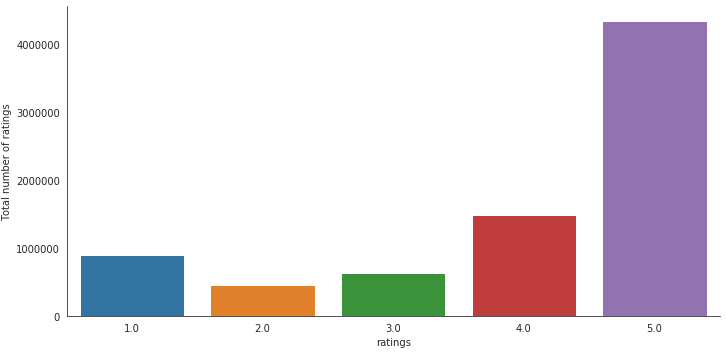

In [10]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df_rating, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

<Figure size 936x432 with 0 Axes>

Text(0.5, 1.0, 'Ratings distribution')

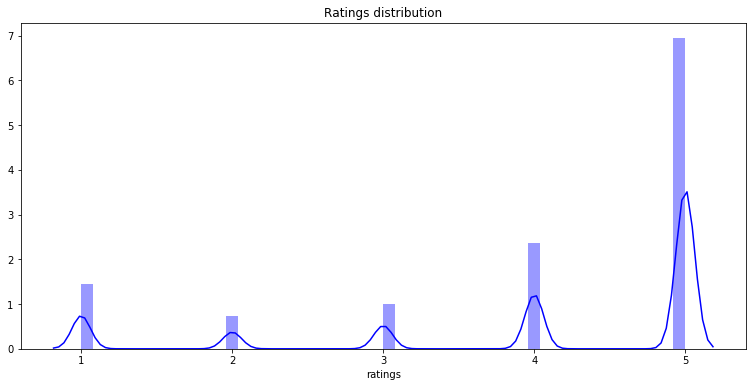

In [44]:
plt.figure(figsize=(13,6))
sns.distplot(df_rating["ratings"],color="b")
plt.title("Ratings distribution")
plt.show()

In [47]:
df_rating['ratings'].value_counts(normalize = True)

5.0    0.555633
4.0    0.189889
1.0    0.115249
3.0    0.080909
2.0    0.058320
Name: ratings, dtype: float64

Mostly users give 5 star rating, as we are observing that 5 star rating cover 55% of the dataset

In [12]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_rating['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_rating['product_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


Taking subset of dataset to make it less sparse/more dense. (As instructed, keeping the users only who has given 50 or more number of ratings)

In [13]:
# Top 10 users based on rating
most_rated = df_rating.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

#### Plot the counts of each rating

In [103]:
# get count of each rating from ratings data
df_ratings_cnt_tmp = pd.DataFrame(df_rating.groupby('ratings').size(), columns=['count'])
df_ratings_cnt_tmp

,count
ratings,
1.0,901765
2.0,456322
3.0,633073
4.0,1485781
5.0,4347541


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [105]:
num_users = len(df_rating.user_id.unique())
num_items = len(df_rating.product_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 4201696 unique users and 476002 unique movies in this data set


In [106]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_rating.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,2000007874910
1.0,901765
2.0,456322
3.0,633073
4.0,1485781
5.0,4347541


The count for zero rating score is too big to compare with others. So let's take log transform for count values and then we can plot them to compare

In [107]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,2000007874910,28.324172
1.0,901765,13.712109
2.0,456322,13.030954
3.0,633073,13.358341
4.0,1485781,14.211451
5.0,4347541,15.285121


Text(0.5, 0, 'item rating score')

Text(0, 0.5, 'number of ratings')

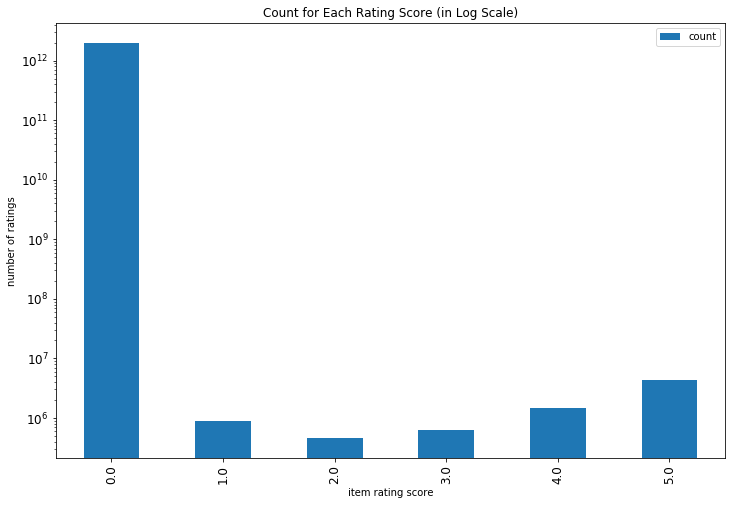

In [108]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("item rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 5 than other scores

#### Plot rating frequency of all items

In [109]:
df_rating.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [112]:
# get rating frequency
df_items_cnt = pd.DataFrame(df_rating.groupby('product_id').size(), columns=['count'])
df_items_cnt.head()

,count
product_id,
0132793040,1
0321732944,1
0439886341,3
0511189877,6
0528881469,27


Text(0.5, 0, 'Product Id')

Text(0, 0.5, 'Number of Ratings')

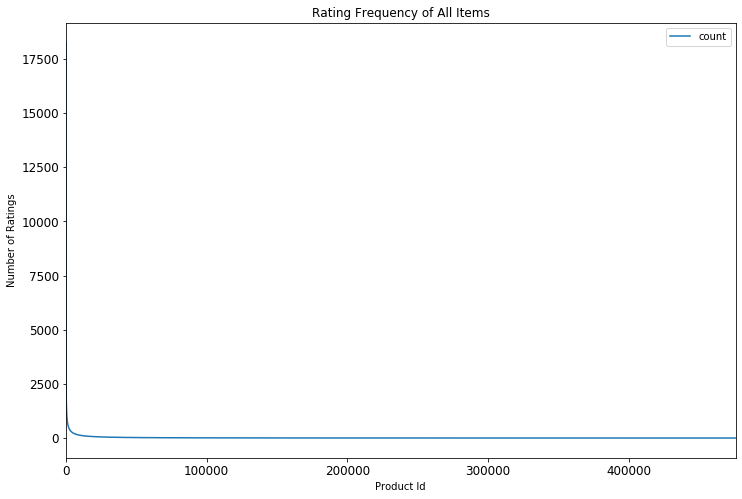

In [113]:
# plot rating frequency of all items
ax = df_items_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Items',
        fontsize=12
    )
ax.set_xlabel("Product Id")
ax.set_ylabel("Number of Ratings")

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

Let's plot the same distribution but with log scale

Text(0.5, 0, 'Product Id')

Text(0, 0.5, 'Number of Ratings (log scale)')

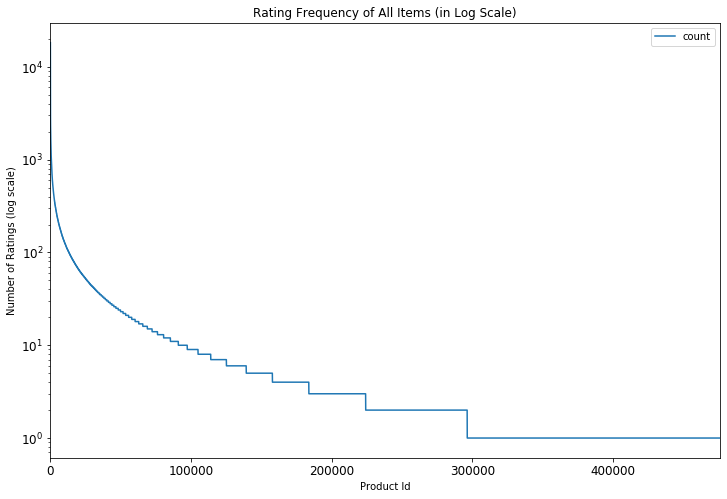

In [114]:
# plot rating frequency of all movies in log scale
ax = df_items_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Items (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("Product Id")
ax.set_ylabel("Number of Ratings (log scale)")

We can see that roughly 1,000 out of 5 lakh products are rated more than 100 times. More interestingly, roughly 1,00,000 out of 5 lakh movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts.

In [115]:
df_items_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    18244.0
0.95       55.0
0.90       25.0
0.85       15.0
0.80       10.0
0.75        7.0
0.70        5.0
0.65        4.0
Name: count, dtype: float64

So about 1% of movies have roughly 18,000 or more ratings, 5% have 55 or more, and 20% have 10 or more. Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 20,000 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.

Memory issue: we don't want to run into the “MemoryError” during model training
Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [117]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_items_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_items = df_rating[df_rating.product_id.isin(popular_movies)]
print('shape of original ratings data: ', df_rating.shape)
print('shape of ratings data after dropping unpopular products: ', df_ratings_drop_items.shape)

shape of original ratings data:  (7824482, 4)
shape of ratings data after dropping unpopular products:  (5374313, 4)


After dropping 75% of items in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [118]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_items.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

,count
user_id,
A00000262KYZUE4J55XGL,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1
A000145014WOTZJ5NSKOR,1
A00015222LZ55IJSVL5IX,1


Text(0.5, 0, 'User Id')

Text(0, 0.5, 'number of ratings')

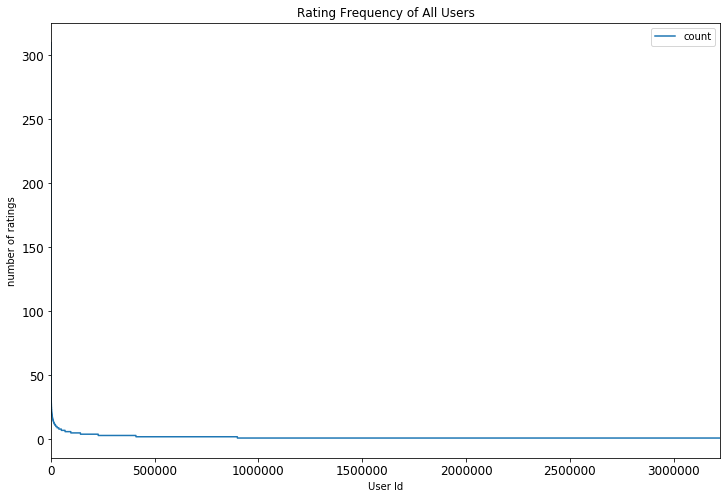

In [119]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings")

In [120]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    310.0
0.95      4.0
0.90      3.0
0.85      2.0
0.80      2.0
0.75      2.0
0.70      1.0
0.65      1.0
0.60      1.0
0.55      1.0
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among products. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating products that they bought. Vast majority of users aren't interested in rating products. So we can limit users to the top 40%, which is about 350 users.

In [123]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_items[df_ratings_drop_items.user_id.isin(active_users)]
print('shape of original ratings data: ', df_rating.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (7824482, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (43506, 4)


## Recommendation Systems using raw data

First I am building recommendation systems using the original data set

#### Data model preparation as per requirement on number of minimum ratings

In [4]:
counts = df_rating['user_id'].value_counts()
counts

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A2L7BK0VBA124A      1
A1URDS3OLOPWCI      1
A2FWL17YND5P7A      1
A3A9D1JFG9HY9T      1
A17NU88TAZQV60      1
Name: user_id, Length: 4201696, dtype: int64

In [5]:
df_final = df_rating[df_rating['user_id'].isin(counts[counts >= 50].index)]

In [7]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['productdf_final has users who have rated 50 or more items_id'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  48190


df_final has users who have rated 50 or more items

Calculating the density of the rating matrix

In [9]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [10]:
final_ratings_matrix.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
product_id,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting data into training and test sets

In [6]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,user_id,product_id,ratings,timestamp
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


In [13]:
train_data.shape
test_data.shape

(88109, 4)

(37762, 4)

##  Popularity Recommender model. (Non-personalised)

In [15]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('product_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head()

,product_id,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [16]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,product_id,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [17]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [22]:
find_recom = [15,121,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

       user_id  product_id  score  Rank
30847       15  B0088CJT4U    133   1.0
30287       15  B007WTAJTO    124   2.0
19647       15  B003ES5ZUU    122   3.0
8752        15  B000N99BBC    114   4.0
30555       15  B00829THK0     97   5.0


Here is the recommendation for the userId: 121

       user_id  product_id  score  Rank
30847      121  B0088CJT4U    133   1.0
30287      121  B007WTAJTO    124   2.0
19647      121  B003ES5ZUU    122   3.0
8752       121  B000N99BBC    114   4.0
30555      121  B00829THK0     97   5.0


Here is the recommendation for the userId: 53

       user_id  product_id  score  Rank
30847       53  B0088CJT4U    133   1.0
30287       53  B007WTAJTO    124   2.0
19647       53  B003ES5ZUU    122   3.0
8752        53  B000N99BBC    114   4.0
30555       53  B00829THK0     97   5.0




Since this is a popularity-based recommender model, recommendations remain the same for all users
We predict the products based on the popularity. It is not personalized to particular user

## Collaborative Filtering model

Model-based Collaborative Filtering: Singular Value Decomposition

In [23]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,user_id,product_id,ratings,timestamp
0,6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
1,4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
2,4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3,3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
4,1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


In [25]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
pivot_df.shape
pivot_df.head()

(1540, 48190)

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [27]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### SVD method

SVD is best to apply on a large sparse matrix

In [28]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [29]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [30]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [31]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 12
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.639356
B000N99BBC                  0.0          1.328095
B00829TIEK                  0.0          1.269074
B008DWCRQW                  0.0          1.145459
B004CLYEDC                  0.0          1.125218


### Evaluation of Model-based Collaborative Filtering (SVD)

In [32]:
# Actual ratings given by the users
final_ratings_matrix.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

product_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [34]:
# Predicted ratings 
preds_df.head()

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [35]:
# Average PREDICTED rating for each item
preds_df.mean().head()

product_id
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [36]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product_id,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [37]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



### Get top - K ( K = 5) recommendations. 

Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [38]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.524522
B00829TIEK                  0.0          1.335672
B000N99BBC                  0.0          1.262374
B008DWCRQW                  0.0          1.062069
B004CLYEDC                  0.0          1.014894


### Popularity based recommnedations using only the highest rated items from the dataset

In [48]:
df_rating.groupby('product_id')['ratings'].mean().sort_values(ascending=False).head()  

product_id
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
Name: ratings, dtype: float64

In [52]:
df_rating.groupby('product_id')['ratings'].count().sort_values(ascending=False).head()  

product_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: ratings, dtype: int64

In [73]:
df_rating.groupby('product_id')['ratings'].mean().sort_values(ascending=False).head()  

product_id
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
Name: ratings, dtype: float64

In [72]:
df_rating.groupby('user_id')['ratings'].count().sort_values(ascending=False).head()

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: ratings, dtype: int64

In [50]:
df_rating['ratings'].mean()

4.012336791112817

In [74]:
df_rating_2 = df_rating[df_rating['user_id'].isin(counts[counts >= 50].index)]

In [75]:
ratings_mean_count = pd.DataFrame(df_rating_2.groupby('product_id')['ratings'].mean()) 

In [77]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df_rating_2.groupby('product_id')['ratings'].count())  

In [78]:
ratings_mean_count.head()

,ratings,rating_counts
product_id,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


The problem with this type of Popularity Based Recommendation is that when one user rates a product as 5.0 that product is going to be in top rated list. But where as a product with 4.8 rating based on 500 users will not be recommended to the user using this system. This is not suitable.

### Summary of recommendation systems based on original data

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history

## Recommendation System based on modified data

Now I am making recommendation systems based on modified dataset where I have previously removed less popular movies and more inactive user.

In [166]:
df_ratings_drop_users.head()

,user_id,product_id,ratings,timestamp
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1335,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1777,A18S2VGUH9SCV5,1400501776,4.0,1340755200
2162,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
2437,A3HPCRD9RX351S,1400532655,3.0,1332028800


In [167]:
df_ratings_drop_users.shape

(43506, 4)

#### KNN model for item-based collaborative filtering

Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an (artist, user) array, where each row is a item and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with items as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [127]:
# pivot and create item-user matrix
item_user_mat = df_ratings_drop_users.pivot(index='product_id', columns='user_id', values='ratings').fillna(0)
# create mapper from item to index
item_to_idx = {
    item: i for i, item in 
    enumerate(list(df_rating.set_index('product_id').loc[item_user_mat.index]))
}
# transform matrix to scipy sparse matrix
item_user_mat_sparse = csr_matrix(item_user_mat.values)

Fitting the Model

Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [129]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(item_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [135]:
# calcuate total number of entries in the item-user matrix
num_entries = item_user_mat.shape[0] * item_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (item_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 99.40% of ratings in our data is missing


The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

### Popularity based recommendation

In [140]:
df_ratings_drop_users.head()

,user_id,product_id,ratings,timestamp
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1335,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1777,A18S2VGUH9SCV5,1400501776,4.0,1340755200
2162,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
2437,A3HPCRD9RX351S,1400532655,3.0,1332028800


In [141]:
final_ratings_matrix = df_ratings_drop_users.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (570, 12645)
given_num_of_ratings =  43506
possible_num_of_ratings =  7207650
density: 0.60%


Observing that the data density is higher than the raw data

In [142]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A105TOJ6LTVMBG,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,...,AX7317G153T8W,AXU3VKZE848IY,AY6A8KPYCE6B0,AYB4ELCS5AM8P,AYLLSFYS3UP1H,AYMD77ITD15PT,AYNAH993VDECT,AZ515FFZ7I2P7,AZAC8O310IK4E,AZMY6E8B52L2T
product_id,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9573212919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_ratings_drop_users, test_size = 0.3, random_state=0)
train_data.head()

,user_id,product_id,ratings,timestamp
184976,A1MZL91Z44RN06,B00006HSYC,5.0,1318982400
534678,A36A1ZYZH8568P,B000629GES,3.0,1171929600
5665641,A2V9DTXTQ5YIMK,B0078GCLRY,5.0,1380240000
4048521,A3IY316DRNF5F2,B004E10KFG,5.0,1352851200
6602720,ARBKYIVNYWK3C,B009F1IO3K,3.0,1362960000


In [144]:
train_data.shape
test_data.shape

(30454, 4)

(13052, 4)

In [145]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('product_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head()

,product_id,score
0,0972683275,1
1,1400501466,1
2,1400501776,1
3,1400532655,2
4,9573212919,1


In [146]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,product_id,score,Rank
8822,B0088CJT4U,91,1.0
5495,B003ES5ZUU,73,2.0
8761,B00829TIEK,67,3.0
4795,B002R5AM7C,65,4.0
2145,B000N99BBC,64,5.0


In [147]:
find_recom = [15,121,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

      user_id  product_id  score  Rank
8822       15  B0088CJT4U     91   1.0
5495       15  B003ES5ZUU     73   2.0
8761       15  B00829TIEK     67   3.0
4795       15  B002R5AM7C     65   4.0
2145       15  B000N99BBC     64   5.0


Here is the recommendation for the userId: 121

      user_id  product_id  score  Rank
8822      121  B0088CJT4U     91   1.0
5495      121  B003ES5ZUU     73   2.0
8761      121  B00829TIEK     67   3.0
4795      121  B002R5AM7C     65   4.0
2145      121  B000N99BBC     64   5.0


Here is the recommendation for the userId: 53

      user_id  product_id  score  Rank
8822       53  B0088CJT4U     91   1.0
5495       53  B003ES5ZUU     73   2.0
8761       53  B00829TIEK     67   3.0
4795       53  B002R5AM7C     65   4.0
2145       53  B000N99BBC     64   5.0




### Item Item Collaborative Filtering

In [149]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,user_id,product_id,ratings,timestamp
0,184976,A1MZL91Z44RN06,B00006HSYC,5.0,1318982400
1,534678,A36A1ZYZH8568P,B000629GES,3.0,1171929600
2,5665641,A2V9DTXTQ5YIMK,B0078GCLRY,5.0,1380240000
3,4048521,A3IY316DRNF5F2,B004E10KFG,5.0,1352851200
4,6602720,ARBKYIVNYWK3C,B009F1IO3K,3.0,1362960000


In [151]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'user_id', columns ='product_id', values = 'ratings').fillna(0)
pivot_df.shape
pivot_df.head()

(570, 12645)

product_id,0972683275,1400501466,1400501776,1400532655,9573212919,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

product_id,0972683275,1400501466,1400501776,1400532655,9573212919,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [154]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product_id,0972683275,1400501466,1400501776,1400532655,9573212919,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
0,-0.003332,-0.003800,0.004818,0.008721,0.005042,0.020444,0.002007,0.002361,-0.042409,0.008424,...,0.070430,0.489116,0.011808,0.042127,0.009234,0.025381,-0.008531,0.065982,0.001690,0.418260
1,0.008194,0.007356,0.021246,0.002426,0.000701,0.008534,0.007318,0.000728,-0.069287,-0.000403,...,0.370424,0.028401,0.018884,0.042483,0.032818,0.237484,0.053965,0.017488,0.011897,0.078795
2,0.005837,0.000047,0.000327,0.002149,0.003692,0.026637,0.003224,0.002344,0.053508,0.003455,...,-0.019797,0.050491,-0.003912,0.010177,0.005355,-0.025085,0.022985,-0.010833,0.001149,0.053363
3,0.016165,0.001285,0.001805,0.001838,0.004438,0.024669,0.001965,0.002937,-0.028416,0.008310,...,0.000570,0.019887,-0.000302,0.028189,0.014550,-0.002775,0.040750,-0.011329,0.001905,-0.002887
4,0.043027,-0.000253,-0.004045,0.006392,0.014093,0.080133,0.004538,0.008493,0.045694,0.027170,...,-0.122742,0.065619,-0.012323,0.059585,0.025339,-0.081170,0.082593,-0.032870,0.000429,0.028825


In [155]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 12
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.459999
B00829TIEK                  0.0          1.174435
B000N99BBC                  0.0          1.169065
B004CLYEDC                  0.0          1.165596
B008DWCRQW                  0.0          1.062911


### Evaluation of Model-based Collaborative Filtering (SVD)

In [158]:
# Actual ratings given by the users
final_ratings_matrix.head()

product_id,0972683275,1400501466,1400501776,1400532655,9573212919,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

product_id
0972683275    0.008772
1400501466    0.005263
1400501776    0.007018
1400532655    0.007018
9573212919    0.008772
dtype: float64

In [160]:
# Predicted ratings 
preds_df.head()

product_id,0972683275,1400501466,1400501776,1400532655,9573212919,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
0,-0.003332,-0.003800,0.004818,0.008721,0.005042,0.020444,0.002007,0.002361,-0.042409,0.008424,...,0.070430,0.489116,0.011808,0.042127,0.009234,0.025381,-0.008531,0.065982,0.001690,0.418260
1,0.008194,0.007356,0.021246,0.002426,0.000701,0.008534,0.007318,0.000728,-0.069287,-0.000403,...,0.370424,0.028401,0.018884,0.042483,0.032818,0.237484,0.053965,0.017488,0.011897,0.078795
2,0.005837,0.000047,0.000327,0.002149,0.003692,0.026637,0.003224,0.002344,0.053508,0.003455,...,-0.019797,0.050491,-0.003912,0.010177,0.005355,-0.025085,0.022985,-0.010833,0.001149,0.053363
3,0.016165,0.001285,0.001805,0.001838,0.004438,0.024669,0.001965,0.002937,-0.028416,0.008310,...,0.000570,0.019887,-0.000302,0.028189,0.014550,-0.002775,0.040750,-0.011329,0.001905,-0.002887
4,0.043027,-0.000253,-0.004045,0.006392,0.014093,0.080133,0.004538,0.008493,0.045694,0.027170,...,-0.122742,0.065619,-0.012323,0.059585,0.025339,-0.081170,0.082593,-0.032870,0.000429,0.028825


In [161]:
# Average PREDICTED rating for each item
preds_df.mean().head()

product_id
0972683275    0.014000
1400501466    0.004089
1400501776    0.007162
1400532655    0.004180
9573212919    0.003167
dtype: float64

In [162]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(12645, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product_id,,,
0972683275,0.008772,0.014000,0
1400501466,0.005263,0.004089,1
1400501776,0.007018,0.007162,2
1400532655,0.007018,0.004180,3
9573212919,0.008772,0.003167,4


In [163]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00793 



### Get top - K ( K = 5) recommendations.

In [164]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B002R5AM7C                  0.0          0.914040
B007WTAJTO                  0.0          0.695259
B0088CJT4U                  0.0          0.599247
B001TH7GUU                  0.0          0.561453
B002V88HFE                  0.0          0.546855


### Deep dive into the bottleneck of item-based collaborative filtering.

    cold start problem
    data sparsity problem
    popular bias (how to recommend products from the tail of product distribution)
    scalability bottleneck

We saw there is 99.40% of user-item interactions are not yet recorded, even after I filtered out less-known items and inactive users. Apparently, we don't even have sufficient information for the system to make reliable inferences for users or items. This is called Cold Start problem in recommender system.

There are three cases of cold start:

    New community: refers to the start-up of the recommender, when, although a catalogue of items might exist, almost no users are present and the lack of user interaction makes very hard to provide reliable recommendations
    New item: a new item is added to the system, it might have some content information but no interactions are present
    New user: a new user registers and has not provided any interaction yet, therefore it is not possible to provide personalized recommendations

We are not concerned with the last one because we can use item-based filtering to make recommendations for new user. In our case, we are more concerned with the first two cases, especially the second case.

The item cold-start problem refers to when items added to the catalogue have either none or very little interactions. This constitutes a problem mainly for collaborative filtering algorithms due to the fact that they rely on the item's interactions to make recommendations. If no interactions are available then a pure collaborative algorithm cannot recommend the item. In case only a few interactions are available, although a collaborative algorithm will be able to recommend it, the quality of those recommendations will be poor. This arises another issue, which is not anymore related to new items, but rather to unpopular items. In some cases (e.g. movie recommendations) it might happen that a handful of items receive an extremely high number of iteractions, while most of the items only receive a fraction of them. This is also referred to as popularity bias. Please recall previous long-tail skewed distribution of movie rating frequency plot.

In addtition to that, scalability is also a big issue in KNN model too. Its time complexity is O(nd + kn), where n is the cardinality of the training set and d the dimension of each sample. And KNN takes more time in making inference than training, which increase the prediction latency

## Another Approach in building Recommendation system using Original Dataset

### Popularity based

In [7]:
users_interactions_count_df = df_rating.groupby(['product_id', 'user_id']).size().groupby('user_id').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 4201696
# users with at least 5 interactions: 254064


In [8]:
interactions_train_df = train_data
interactions_test_df = test_data

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 88109
# interactions on Test set: 37762


In [21]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = df_rating.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

In [23]:
interactions_test_indexed_df.index.unique().values

array(['A3JU990UTN5RQP', 'A2VJ5ALN1BIV3B', 'A2NQMVTQ4PVLL', ...,
       'A30JPZ9TZ7I61U', 'A1NMM0RDRF6R84', 'A3QKIR8J56EUI1'], dtype=object)

In [10]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = df_rating.loc[user_id]['product_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [24]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, user_id, sample_size, seed=0):
        interacted_items = get_items_interacted(user_id, interactions_full_indexed_df)
        all_items = set(df_rating['product_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(0)
        non_interacted_items_sample = random.sample(non_interacted_items, 100)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, user_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[user_id]
        if type(interacted_values_testset['product_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['product_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['product_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(user_id, 
                                               items_to_ignore=get_items_interacted(user_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(user_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=product_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([product_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['product_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['product_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(product_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(product_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
         
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, user_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, user_id) 
            person_metrics['user_id'] = user_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [12]:
#Computes the most popular items
item_popularity_df = df_rating.groupby('product_id')['ratings'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,product_id,ratings
0,B0074BW614,81943.0
1,B00DR0PDNE,64681.0
2,B007WTAJTO,62697.0
3,B0019EHU8G,58409.0
4,B006GWO5WK,52751.0
5,B003ELYQGG,51028.0
6,B003ES5ZUU,48346.0
7,B007R5YDYA,46473.0
8,B00622AG6S,43419.0
9,B0002L5R78,42204.0


In [19]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['product_id'].isin(items_to_ignore)] \
                               .sort_values('ratings', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'product_id', 
                                                          right_on = 'product_id')[['ratings', 'product_id']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, df_rating)

In [28]:
popularity_model.recommend_items('A5JLAU2ARJ0BO',[],10)

,product_id,ratings
0,B0074BW614,81943.0
1,B00DR0PDNE,64681.0
2,B007WTAJTO,62697.0
3,B0019EHU8G,58409.0
4,B006GWO5WK,52751.0
5,B003ELYQGG,51028.0
6,B003ES5ZUU,48346.0
7,B007R5YDYA,46473.0
8,B00622AG6S,43419.0
9,B0002L5R78,42204.0


In [29]:
popularity_model.recommend_items('A2WNBOD3WNDNKT',[],10)

,product_id,ratings
0,B0074BW614,81943.0
1,B00DR0PDNE,64681.0
2,B007WTAJTO,62697.0
3,B0019EHU8G,58409.0
4,B006GWO5WK,52751.0
5,B003ELYQGG,51028.0
6,B003ES5ZUU,48346.0
7,B007R5YDYA,46473.0
8,B00622AG6S,43419.0
9,B0002L5R78,42204.0


We can see that for all users it is returning the same 10 recommendations since this Popularity based is not a personalized Recommendation.

### Collaborative filtering

In [30]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='user_id', 
                                                          columns='product_id', 
                                                          values='ratings').fillna(0)

users_items_pivot_matrix_df.head(10)

product_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400698987,...,B00L26YDA4,B00L3YHF6O,B00L403O94,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGQ6HL8,B00LI4ZZO8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10H24TDLK2VDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['A100UD67AHFODS',
 'A100WO06OQR8BQ',
 'A105S56ODHGJEK',
 'A105TOJ6LTVMBG',
 'A10AFVU66A79Y1',
 'A10H24TDLK2VDP',
 'A10NMELR4KX0J6',
 'A10O7THJ2O20AG',
 'A10PEXB6XAQ5XF',
 'A10X9ME6R66JDX']

In [40]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 10
#Performs matrix factorization of the original user item matrix
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [41]:
U.shape

(1540, 10)

In [42]:
Vt.shape

(10, 38226)

In [43]:
sigma = np.diag(sigma)
sigma.shape

(10, 10)

In [44]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 2.80271974e-03,  2.90659840e-03,  5.83498710e-04, ...,
         5.82841620e-03,  7.98490902e-02,  1.11328518e-02],
       [ 3.10854918e-03,  3.21166241e-03,  7.06509860e-04, ...,
         4.42291925e-04, -1.65376307e-02, -2.64036470e-03],
       [-1.18990521e-03, -5.25878768e-04, -2.31680753e-04, ...,
        -1.78945113e-03,  1.28558948e-02,  5.14988097e-03],
       ...,
       [ 5.92547477e-03,  7.35071856e-03,  1.68114001e-03, ...,
         3.65852659e-02,  3.33602044e-01,  9.08134651e-02],
       [ 5.95871312e-04,  7.34648056e-04,  1.65039945e-04, ...,
         1.02939450e-03,  7.93201042e-03,  1.86722621e-03],
       [ 8.68303494e-04,  7.38969538e-04,  1.78199297e-04, ...,
        -3.45560876e-04, -1.16772847e-02,  1.82715509e-03]])

In [45]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
product_id,,,,,,,,,,,,,,,,,,,,,
0594451647,0.002803,0.003109,-0.001190,0.001841,0.000772,0.000081,0.002094,0.007247,0.001770,0.004264,...,0.001548,0.001298,0.001817,0.003274,0.003472,0.001873,0.001141,0.005925,0.000596,0.000868
0594481813,0.002907,0.003212,-0.000526,0.002013,0.000944,0.000566,0.002401,0.008545,0.001649,0.004713,...,0.001468,0.001023,0.000781,0.003388,0.004643,0.001859,0.001326,0.007351,0.000735,0.000739
0970407998,0.000583,0.000707,-0.000232,0.000416,0.000205,0.000128,0.000463,0.001661,0.000362,0.000990,...,0.000344,0.000257,0.000351,0.000734,0.000973,0.000430,0.000284,0.001681,0.000165,0.000178
0972683275,0.013599,0.012676,0.022969,0.009039,0.011278,0.001727,0.011292,0.042546,0.019640,0.021190,...,0.003372,0.003497,0.001825,0.013951,0.012996,0.006349,0.002819,-0.002587,0.000807,0.001286
1400501466,0.002498,0.004772,0.007984,0.002038,0.003598,0.004958,0.002135,0.004985,0.007011,0.003879,...,0.001692,0.001457,0.004481,0.002388,0.007718,0.001390,0.000691,-0.000765,0.001705,0.000915
1400501776,0.001990,0.011356,0.006210,0.002471,0.003254,0.011895,0.002411,0.002890,0.008551,0.004950,...,0.003071,0.003559,0.010252,0.002575,0.015871,0.002780,0.002540,0.010737,0.003226,0.002906
1400532620,0.001178,0.000026,0.005798,0.000461,0.001848,0.000738,0.000847,0.001986,0.003245,0.000871,...,-0.000016,0.000016,0.000232,0.000436,0.001733,-0.000279,-0.000269,-0.005981,0.000341,-0.000187
1400532655,0.014636,0.002907,-0.003373,0.005429,0.001399,-0.004618,0.009806,0.020623,0.002953,0.010671,...,0.002434,0.001684,0.001567,0.008542,0.012583,0.004560,0.002823,0.025195,0.005858,0.001286
1400599997,0.000892,0.005662,0.008516,0.001500,0.003793,0.008221,0.001664,0.001797,0.007531,0.003186,...,0.002138,0.001703,0.007121,0.001762,0.011305,0.001187,0.001023,-0.002269,0.002484,0.001217


In [46]:
len(cf_preds_df.columns)

1540

In [47]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'ratings'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['product_id'].isin(items_to_ignore)] \
                               .sort_values('ratings', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'product_id', 
                                                          right_on = 'product_id')[['ratings', 'product_id']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, df_rating)

In [51]:
cf_recommender_model.recommend_items('A5JLAU2ARJ0BO',[],10)

,product_id,ratings
0,B0036Q7MV0,5.610497
1,B00006B7HB,5.566644
2,B00825BZUY,5.534866
3,B00008OE6I,5.413079
4,B00004TS16,5.404551
5,B00005QFZG,5.389484
6,B0000658CG,5.351684
7,B000066E70,5.351684
8,B00009Q96Z,5.311749
9,B000M17AVO,5.289351


In [54]:
cf_recommender_model.recommend_items('A10X9ME6R66JDX',[],10)

,product_id,ratings
0,B007WTAJTO,1.415519
1,B003ES5ZUU,0.976809
2,B002V88HFE,0.602325
3,B001TH7GUU,0.551733
4,B005FYNSPK,0.537831
5,B002WE6D44,0.526196
6,B005HMKKH4,0.459731
7,B0041Q38NU,0.455007
8,B001E1Y5O6,0.449103
9,B000QUUFRW,0.422193


This recommendation system hence personalizes the products for users as expected.

## Conclusion

The Item Item Collaborative Filtering recommendation systems made with raw data gave less RMSE than the one made with modified data by deleting less popular movies and more inactive users. That means there must be some overfitting of data in the latter case and hence the predictions are more error prone.

The Popularity based Recommendation system in both the cases seem to be predicting the same set of products to the user but in different order. That is fine because with reduced number of data in the dataset, it is predicting the same ones that the model predicted with raw data.

Popularity based is used for new users and Collaborative filtering is used for old users for better business purpose.